# Monte Carlo Radiative Transfer

Running this notebook requires https://github.com/JuliaLang/IJulia.jl which prerequisites:
- Python
- Pip
- Jupyter notebook
- Julia

All code is written by scratch, inspired by the repo https://github.com/unoebauer/mcrtreview-tools. All theory is summarized from "Monte Carlo Radiative Transfer" by Noebauer and Sim.
## Background

### Important Variables

- Specific Intensity $I_v$ or $I(\mathbf{x}, t, \nu)$
- $\mathbf{x}$ position in space
- $\mu$ propagation direction
- $t$ time
- $\nu$ frequency
- $\chi_a$ absorption coefficient
- $\chi_s$ scattering coefficient
- $\chi_t = \chi_a + \chi_s$ total extinction coefficient or opacity

The radiative transfer equation describes the propagation of light through a medium. Let us start by assuming the light propagates through empty space then

$$
\frac{dI_v}{ds} = 0
$$

where $I$ is the intensity of light and $s$ is the distance traveled. Let us add a radiation absorbing medium to the mix. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v
$$

where $\alpha$ is the *fractioanl depletion coefficient* per path length. We can define the optical depth $\tau$ as

$$
d \tau_v = -\alpha_v ds
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = -I_v
$$

However radiation can also travel through a radiation emitting medium. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v + j_v
$$

where $j$ is the *emission coefficient*. We can also define it in terms of the optical depth

$$
\frac{dI_v}{d\tau_v} = \frac{j_v}{\alpha_v} - I_v.
$$

We then define the source function as 

$$
S_v = \frac{j_v}{\alpha_v}
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = S_v - I_v.
$$

## MCRT 

We can simulate the radiative transfer equation using Monte Carlo methods. We leverage an abstraction called photon packets, or machine photons, where a number of photons are grouped together. The photons are described by their position, direction, frequency, energy and weight. Over the course of the simulation, each photon packet continously accumulates optical depth. Hence contrary to classical simulations, we do not integrate over time but over optical depth.



We treat interactions with the medium as discrete interaction events, hence the MC algorithm needs to find when those events occur. We denote a random number as $\xi$. At the beginning of each packet trajectory event, each packet is assigned a new optical depth distance to the next interaction by

$$
\tau = -\log(\xi)
$$

we then compute the length of the path in physical space by dividing the optical depth by the total extinction coefficient $\chi_a$

$$
l = \frac{\tau}{\chi_a}
$$

or if we include scattering

$$
l = \frac{\tau}{\chi_t}.
$$

We can then update the position of the photon packet by

$$
\mathbf{x} = \mathbf{x} + l \mathbf{\mu}
$$

where $\mathbf{\mu}$ is the direction of the photon packet. For the case of pure absorption, the packet is absorbed and the simulation ends. If we include scattering, we need to determine if the photon packet is scattered which happens when

$$
\xi \leq \frac{\chi_s}{\chi_t}
$$

where $\xi$ is a random number between 0 and 1. If the photon packet is scattered, we need to draw a new direction for the photon packet

$$
\mathbf{\mu} = \xi - 1.
$$

## Julia implementation

Let us now implement the above with Julia

In [1]:
using Plots

First we create a new data structure which stores the Photon Packets data. 

In [2]:
# We define the Photon Packets
mutable struct PP
    # position in optical depth space
    x::AbstractArray{Float64, 1}
    # propagation direction
    mu::AbstractArray{Float64, 1}
    # energy 
    E::AbstractArray{Float64, 1}
    # state of the packet, False means the photon has escaped
    absorbed::AbstractArray{Bool, 1}
    escaped::AbstractArray{Bool, 1}
end

We then code the event function, which is responsible to update the states of all photon packets at any moment in time. We implement it right away with a scattering and non scattering version. 

In [3]:
mutable struct Params
    # uniform temperature of the medium
    T::Float64
    # scattering coefficient
    chi_scattering::Float64
    # absorbtion coefficient
    chi_absorbtion::Float64
    # radius of the sphere in m
    radius::Float64
    # number of packets
    N::Int
    # density sampling function
    density::Function
    # enable scattering -> Drawing new directions
    enable_scattering::Bool
    # radiation constant, J m^-3 K^-4
    C::Float64
end

function event!(pp::PP, params::Params)::Nothing

    N = size(pp.x)[1]

    # sample optical depth to next event
    tau_to_next = -log.(rand(Float64, N))

    # set chi total / opacity 
    chi_tot = params.chi_absorbtion
    if params.enable_scattering
        chi_tot += params.chi_scattering
    end
    
    # Invert the optical depth to get the phyiscal distance. 
    # Note that this is an approximation, as we cannot invert the integral over chi as there is no unique solution (?)
    l_to_next = tau_to_next ./ chi_tot

    # Update the state of the packets
    pp.x .+= l_to_next .* pp.mu

    # Decide if packets crossed boundaries
    escaped = (pp.x .> params.radius) .|| (pp.x .< -params.radius)

    # Update the escape state of the packets
    pp.escaped = pp.escaped .|| (escaped .&& .!pp.absorbed)

    # Decide if packets are scattered or absorbed 
    if params.enable_scattering
        is_scattered = rand(N) .< (params.chi_scattering / chi_tot)
        # Update the scatter state of the packets
        pp.absorbed = pp.absorbed .|| (.!is_scattered .&& .!pp.escaped)
        # Scatter the packets -> Draw new propagation directions            
        pp.mu = rand(Float64, N) .* .2  .- 1
    else
        # in the absorbtion only case, all packets which do not escape are absorbed
        pp.absorbed = .!pp.escaped
    end

    return nothing
end

event! (generic function with 1 method)

Now we implement the entire MRCT simulation. 

In [4]:
function init_packets(params::Params)::PP

    # Initialize the packets
    volume = 4/3 * pi * params.radius^3
    # Same formula if oparating in optical depth or physical space
    uniform_sphere_radius = params.radius .* rand(Float64, params.N).^(1 ./3)

    return PP(
        # sample position from the density profile
        params.density(uniform_sphere_radius),
        # initial velocity is randomly distributed between -1 and 1
        rand(Float64, params.N) .* 2 .- 1,
        # initial energy
        ones(Float64, params.N) * params.C * params.T^4 * volume / params.N,
        # all packets start as not absorbed and not escaped
        zeros(Bool, params.N),
        zeros(Bool, params.N))
end

init_packets (generic function with 1 method)

In [5]:
function mcrt!(
        packets :: PP,
        params :: Params) :: Nothing

    # Loop over packets until all are absorbed or have escaped
    while !all((packets.absorbed .|| packets.escaped))
        event!(packets, params)
    end

    return nothing
end

mcrt! (generic function with 1 method)

## Sampling from density profile B

We are given the function 
$$
f(r) = \frac{1}{(r + \delta)^2}.
$$
To sample from the function we to find the inverse of the Integral. Therefore we start with the integral
$$
F(r) = -\frac{1}{r + \delta}
$$
then we invert the function and get
$$
F^{-1} = \delta \frac{1}{r}.
$$
We can now plug in a random distribution as $r$ to sample from the density profile function $f(r)$. We can verify this visually:

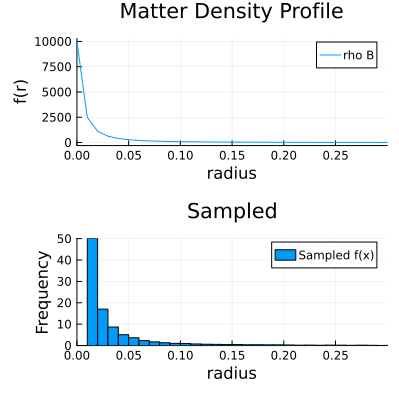

In [6]:
delta = 0.01
profile_B = x -> 1 ./ (x .+ delta).^2
sample_B = x -> delta .* 1 ./ x
sample_A = x -> x

x = 0:0.01:1
y = profile_B(x)

# two plots with shared x-axis
p1 = plot(x, y, label="rho B", xlabel="radius", ylabel="f(r)", title="Matter Density Profile", xlim=(0, 0.3))

x = rand(Float64, 10000)
y = sample_B(x)

bins = 0:0.01:1
p2 = histogram(y, label="Sampled f(x)", xlabel="radius", ylabel="Frequency", title="Sampled", xlim=(0, 0.3), normalize=:pdf, bins=bins)

plot(p1, p2, layout=(2, 1), legend=true, size=(400, 400))

In [7]:
# uniform sampling from sphere



In [8]:
function run_mcrt(
    params :: Params,
) :: PP
    packets = init_packets(params)
    mcrt!(packets, params)
    return packets
end

run_mcrt (generic function with 1 method)

We also add the analytic solution.

In [9]:
function p_esc_analytic(t::Float64)::Float64
    """Calculate the escape probability analytically

    Note: it is assumed that there is no scattering within the sphere, but
    that photons/packets can only be absorbed.

    """
    return (3. / (4. * t) * (1. - 1. / (2. * t^2) + (1. / t + 1. / (2. * t^2)) * exp(-2. * t)))

end

p_esc_analytic (generic function with 1 method)

## Escape probability

Task 1: escape probability without scattering. 

In [10]:
resolution = 30
n_packets = 50000

# J m^-3 K^-4, source: https://scienceworld.wolfram.com/physics/RadiationConstant.html
radiation_constant :: Float64 = 7.5657e-16

chi_absorbtion = 1.0
chi_total = chi_absorbtion
temperature = 1.0

esc_prob_A = zeros(resolution)
esc_prob_B = zeros(resolution)
esc_prob_analytic = zeros(resolution)

optical_depth = 10.0.^LinRange(-2, 2, resolution)
radius = optical_depth ./ chi_total

params = Params(
    temperature,
    0,  # scattering
    chi_absorbtion,
    0, # radius
    n_packets,
    sample_A, # density Function
    false,
    radiation_constant)

for i in 1:resolution

    params.radius = radius[i]
    params.density = sample_A
    
    packets_A = run_mcrt(params)
    esc_prob_A[i] = sum(packets_A.escaped) / n_packets

    params.density = sample_B
    packets_B = run_mcrt(params)
    esc_prob_B[i] = sum(packets_B.escaped) / n_packets

    esc_prob_analytic[i] = p_esc_analytic(optical_depth[i])
end


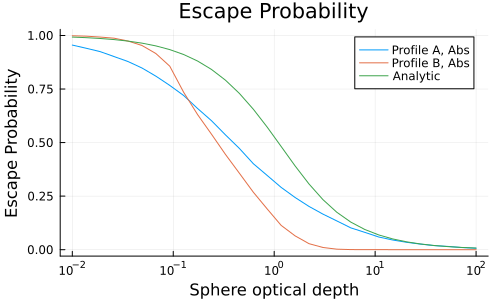

In [11]:
# x axis in log
plot(optical_depth, esc_prob_A, xaxis=:log, label="Profile A, Abs", size=(500, 300))
plot!(optical_depth, esc_prob_B, xaxis=:log, label="Profile B, Abs")
plot!(optical_depth, esc_prob_analytic, xaxis=:log, label="Analytic", xlabel="Sphere optical depth", ylabel="Escape Probability", title="Escape Probability")   
# add x and y labels
xlabel!("Sphere optical depth")
ylabel!("Escape Probability")
# add title 
title!("Escape Probability")

## Energy Flux

One part of the task is to find the energy flux of the sphere, as a function of optical depth.
To do so, we need to know the amount of energy a photon packet has stored. 